<a href="https://colab.research.google.com/github/ryaltic/Modeling-Ranked-Match-Outcomes-Using-Early-Game-Performance-Data-in-League-of-Legends/blob/main/Modeling_Ranked_Matches_Outcomes_LOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Ranked Matches in League of Legends at minute 10

This script will use data from Riot's API to model outcomes of ranked matches to determine how well can League of Legends ranked matches can be predicted in the early game. The matches uses ranked matches from North America region and from Gold to Diamond elo. Another outcome of this script is to see what factors influence ranked matches the most. This script will go through the whole process of the data science workflow with the expection of pulling the data through the API for privacy reason.

## Loading the data and doing Pre-processing

In [121]:
# Loading the pandas package
import pandas as pd

In [122]:
# Loading in the data file from my github
matches = pd.read_csv('https://raw.githubusercontent.com/ryaltic/Modeling-Ranked-Match-Outcomes-Using-Early-Game-Performance-Data-in-League-of-Legends/refs/heads/main/league_matches_data.csv')

In [123]:
# Displaying the first few rows
matches.head()

,match_id,minute,game_duration,blue_win,game_version,Blue_TOP_kills,Blue_TOP_gold,Blue_TOP_xp,Blue_TOP_cs,Blue_TOP_wards_placed,...,Blue__gold,Blue__xp,Blue__cs,Blue__wards_placed,Blue__wards_killed,Red__gold,Red__xp,Red__cs,Red__wards_placed,Red__wards_killed
0,5228482907,5,1666,1,15.3.656.4086,1,1698,2050,22,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5228482907,10,1666,1,15.3.656.4086,0,3262,4551,49,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5228482907,15,1666,1,15.3.656.4086,1,5214,6996,86,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5210847800,5,1848,1,15.1.649.4112,0,1643,1648,13,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5210847800,10,1848,1,15.1.649.4112,0,3236,4174,44,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Each match contains three data points and shows all information about the match at that current moment. There are a few columns that has information about the game not pertaining to that current moment in time which are game duration, the team that won, the game version and match id. The columns are named well but there will need to be some conversions that will need to be done.  

In [124]:
# Displaying the columns and column types
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80515 entries, 0 to 80514
Data columns (total 79 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   match_id                   80515 non-null  int64  
 1   minute                     80515 non-null  int64  
 2   game_duration              80515 non-null  int64  
 3   blue_win                   80515 non-null  int64  
 4   game_version               80515 non-null  object 
 5   Blue_TOP_kills             80515 non-null  int64  
 6   Blue_TOP_gold              80515 non-null  int64  
 7   Blue_TOP_xp                80515 non-null  int64  
 8   Blue_TOP_cs                80515 non-null  int64  
 9   Blue_TOP_wards_placed      80515 non-null  int64  
 10  Blue_TOP_wards_killed      80515 non-null  int64  
 11  Blue_JUNGLE_kills          80515 non-null  int64  
 12  Blue_JUNGLE_gold           80515 non-null  int64  
 13  Blue_JUNGLE_xp             80515 non-null  int

Most of the columns are numeric and there are a few columns that have a majority of the data missing which will be dropped. The columns that are going to be dropped are team totals that can be remade.

In [125]:
# Displaying the shape of the df
matches.shape

(80515, 79)

There are a total of 80,515 rows and 79 columns from the csv file. There is around 27,000 individual matches.

In [126]:
# Dropping the columns that were majority missing
matches = matches.drop(labels= ['Blue__gold', 'Blue__xp', 'Blue__cs', 'Blue__wards_placed', 'Blue__wards_killed',
                                'Red__gold', 'Red__xp', 'Red__cs', 'Red__wards_placed', 'Red__wards_killed'],
                        axis = 1)

In [127]:
# Only keeping rows that are at 15 minutes
matches_10 = matches[matches['minute'] == 10]
print(matches_10.head())
print(matches_10.shape)

      match_id  minute  game_duration  blue_win    game_version  \
1   5228482907      10           1666         1   15.3.656.4086   
4   5210847800      10           1848         1   15.1.649.4112   
7   5208847505      10           1484         1   15.1.649.4112   
10  5197140868      10           2007         1  14.24.644.2327   
13  5197107354      10           1857         1  14.24.644.2327   

    Blue_TOP_kills  Blue_TOP_gold  Blue_TOP_xp  Blue_TOP_cs  \
1                0           3262         4551           49   
4                0           3236         4174           44   
7                0           4085         5173           85   
10               0           2542         4280           36   
13               1           4177         4976           75   

    Blue_TOP_wards_placed  ...  Red_UTILITY_kills  Red_UTILITY_gold  \
1                       0  ...                  0              3116   
4                       0  ...                  0              2448   
7    

26,833 rows after filtering to matches at 10 minute time frame

In [128]:
# Checking for duplicate matches
matches_10.duplicated(subset = 'match_id').sum()

np.int64(0)

No duplicate matches

In [129]:
# Dropping more columns that are no longer needed
matches_10 = matches_10.drop(labels = ['minute','game_version','match_id','game_duration'], axis = 1)

Minute is no longer needed now that all games are 10 minutes, game version isn't need as the dataset doesn't have champions so the game version doesn't give any information. After checking for duplicated match_id is not needed anymore and game_duration was removed because it gave information about the game after the game was over.

In [130]:
# Redefining the target variable for more clarity
matches_10['winner'] = matches_10['blue_win'].map({1: 'Blue', 0: 'Red'})

matches_10 = matches_10.drop(labels = ['blue_win'], axis = 1)

## Splitting into Training and Testing Sets

In [131]:
# Defining the x and y datasets
X = matches_10.drop(labels = ['winner'], axis = 1)
y = matches_10['winner']

In [132]:
# Importing the necessary package
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

## Distribution Checks

In [138]:
# Checking the distribuation of the y data sets
print(y_train.value_counts())
print(y_test.value_counts())

winner
Blue    11012
Red     10454
Name: count, dtype: int64
winner
Blue    2718
Red     2649
Name: count, dtype: int64


The distributions for both y datasets are roughly even and the data is balanced for the response variable

In [133]:
# Checking the distribution of all categorical variables
def categorical_variables_dist(df):
  cat_columns = df.select_dtypes(include = ['object','category','bool']).columns
  for col in cat_columns:
    print(df[col].value_counts())

# Using the function on the train and test for the X data set
print(categorical_variables_dist(X_train))
print(categorical_variables_dist(X_test))

None
None


We have no categorical variables in the X datasets

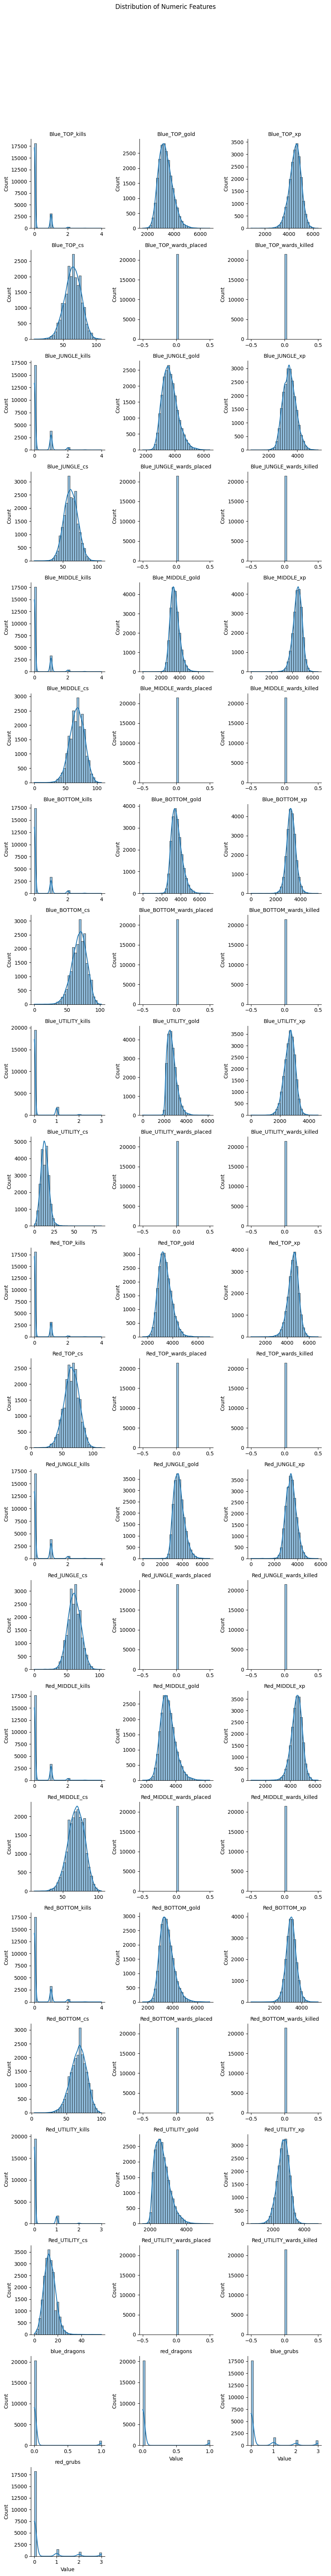

None


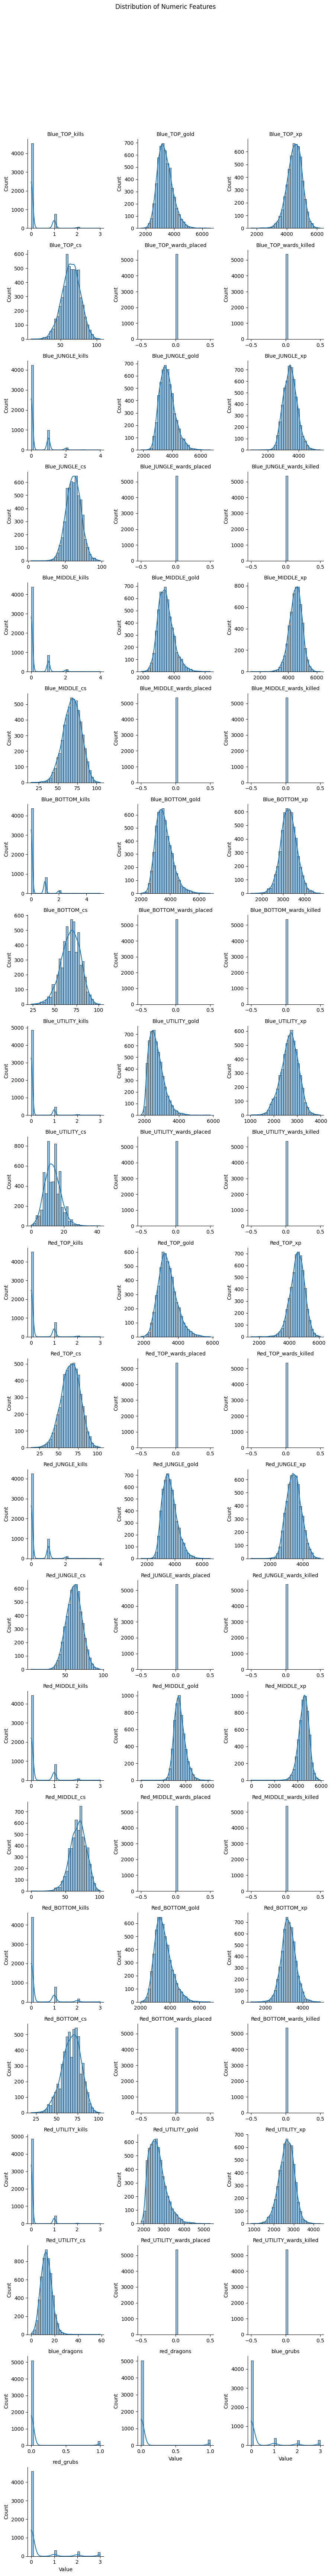

None


In [134]:
# Importing the needed packages
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a function to plot the distribution of numeric features
def numerical_variables_dist(df, title="Distribution of Numeric Features", col_wrap=3, bins=30, kde=True):
    numeric_columns = df.select_dtypes(include="number") # selecting only numeric columns
    if numeric_columns.empty: # error checking
        print("No numeric columns found.")
        return
    # Melting the columns
    df_long = numeric_columns.melt(var_name="Feature", value_name="Value")

    # Making a facetgrid to display all of the numeric columns
    g = sns.FacetGrid( # assigning the facetgrid to g
        df_long, # using the melted df
        col="Feature",
        col_wrap=col_wrap,
        sharex=False,
        sharey=False
    )

    g.map(sns.histplot, "Value", bins=bins, kde=kde) # using seaborn histogram
    g.set_titles("{col_name}")
    g.fig.suptitle(title, y=1.05)

    plt.show() # showing the plot


# Using the function on the X datasets
print(numerical_variables_dist(X_train))
print(numerical_variables_dist(X_test))


After a brief look through of the numeric variables it is clear that some of the variables did not get pulled correctly so those variables will be dropped.

In [135]:
# Dropping the variables that didn't pull correctly
X_train = X_train.drop(labels = ['Blue_TOP_cs', 'Red_TOP_cs', 'Blue_JUNGLE_cs', 'Red_JUNGLE_cs','Blue_MIDDLE_cs', 'Red_MIDDLE_cs','Blue_BOTTOM_cs', 'Red_BOTTOM_cs',
                                 'Blue_UTILITY_cs', 'Red_UTILITY_cs', 'Blue_UTILITY_wards_placed', 'Red_UTILITY_wards_placed', 'Blue_BOTTOM_wards_placed', 'Red_BOTTOM_wards_placed',
                                 'Blue_MIDDLE_wards_placed', 'Red_MIDDLE_wards_placed', 'Blue_JUNGLE_wards_placed', 'Red_JUNGLE_wards_placed', 'Blue_TOP_wards_placed', 'Red_TOP_wards_placed',
                                 'Blue_UTILITY_wards_killed', 'Red_UTILITY_wards_killed', 'Blue_BOTTOM_wards_killed', 'Red_BOTTOM_wards_killed',
                                 'Blue_MIDDLE_wards_killed', 'Red_MIDDLE_wards_killed', 'Blue_JUNGLE_wards_killed', 'Red_JUNGLE_wards_killed',
                                 'Blue_TOP_wards_killed', 'Red_TOP_wards_killed'
                                 ], axis = 1)
X_test = X_test.drop(labels = ['Blue_TOP_cs', 'Red_TOP_cs', 'Blue_JUNGLE_cs', 'Red_JUNGLE_cs','Blue_MIDDLE_cs', 'Red_MIDDLE_cs','Blue_BOTTOM_cs', 'Red_BOTTOM_cs',
                                 'Blue_UTILITY_cs', 'Red_UTILITY_cs', 'Blue_UTILITY_wards_placed', 'Red_UTILITY_wards_placed', 'Blue_BOTTOM_wards_placed', 'Red_BOTTOM_wards_placed',
                                 'Blue_MIDDLE_wards_placed', 'Red_MIDDLE_wards_placed', 'Blue_JUNGLE_wards_placed', 'Red_JUNGLE_wards_placed', 'Blue_TOP_wards_placed', 'Red_TOP_wards_placed',
                                 'Blue_UTILITY_wards_killed', 'Red_UTILITY_wards_killed', 'Blue_BOTTOM_wards_killed', 'Red_BOTTOM_wards_killed',
                                 'Blue_MIDDLE_wards_killed', 'Red_MIDDLE_wards_killed', 'Blue_JUNGLE_wards_killed', 'Red_JUNGLE_wards_killed',
                                 'Blue_TOP_wards_killed', 'Red_TOP_wards_killed'
                                 ], axis = 1)

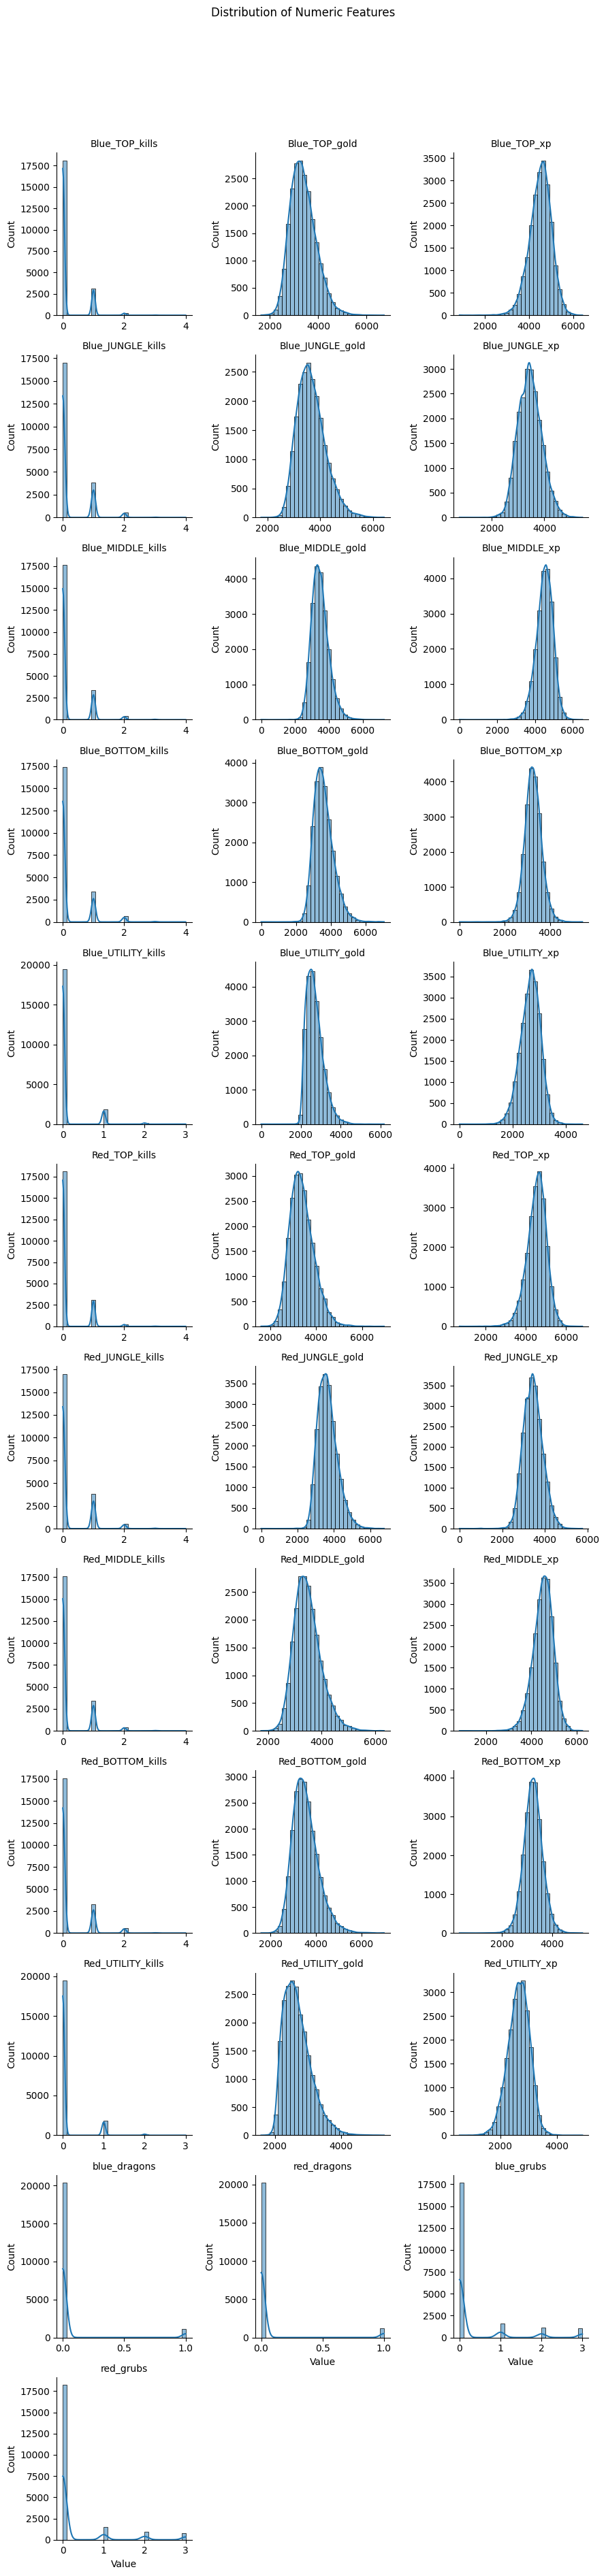

None


In [136]:
# Checking again
print(numerical_variables_dist(X_train))

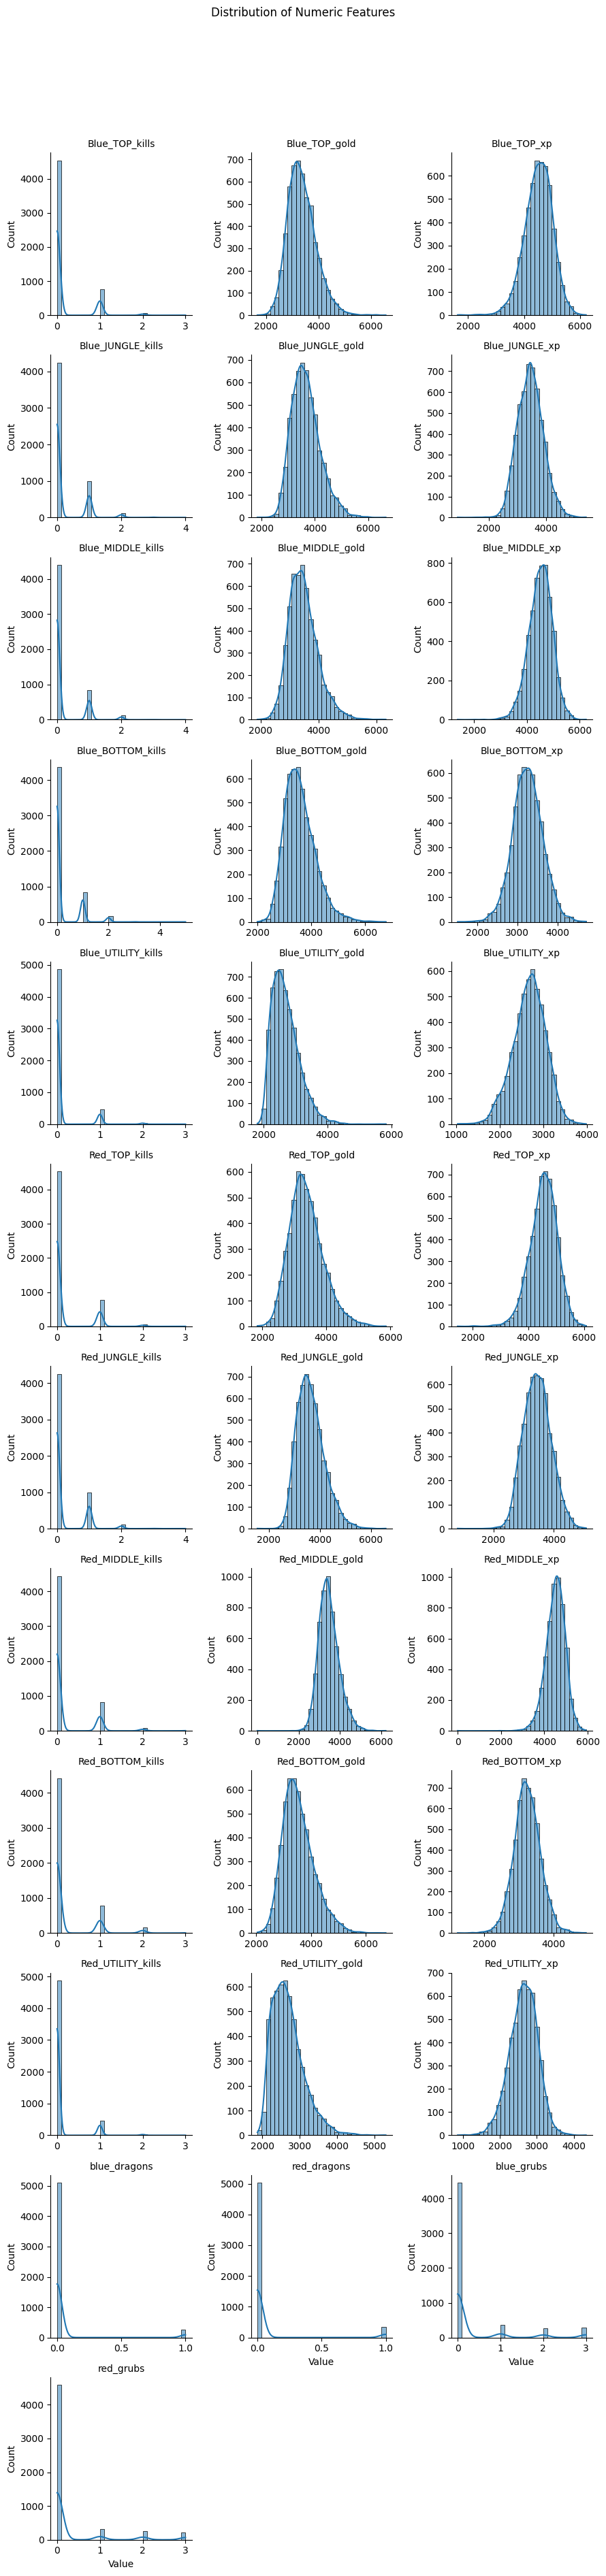

None


In [137]:
# Checking again
print(numerical_variables_dist(X_test))

The XP and Gold variables for all roles in both dataset are basically evenly distributed with a little tail on the right side meaning there is a slight right skewed for those variables but nothing too major. For the Kills variables we can see for both data set and all roles it is right skewed with most of the data points being at zero. On top of that, the grubs and dragon variables for both data sets and teams are right skewed with most of the data points being at zero. All of the variables and values make logical sense for a Ranked League of Legends match at minute 10 and applying transformations to some of the columns is an option down the line before modeling.


EDA Visuals and Feature Enginneering